In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error
import xgboost as xgb

/Users/fredlu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fredlu/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv("dataclean/trip.csv")
weather = pd.read_csv("dataclean/weather.csv")
stations = pd.read_csv("dataclean/station.csv")
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [3]:
df.duration.describe()

count    6.699590e+05
mean     1.107950e+03
std      2.225544e+04
min      6.000000e+01
25%      3.440000e+02
50%      5.170000e+02
75%      7.550000e+02
max      1.727040e+07
Name: duration, dtype: float64

In [4]:
#Change duration from seconds to minutes
df.duration /= 60
df.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

In [5]:
df['duration'].quantile(0.995)
df = df[df.duration <= 360]
df.shape

(666872, 11)

In [6]:
df.start_date = pd.to_datetime(df.start_date, format='%m/%d/%Y %H:%M')

In [7]:
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,1.183333,2013-08-29 10:16:00,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [8]:
df['date'] = df.start_date.dt.date
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127,2013-08-29
1,4607,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138,2013-08-29
2,4130,1.183333,2013-08-29 10:16:00,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214,2013-08-29
3,4251,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060,2013-08-29
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103,2013-08-29


In [9]:
dates = {}
for d in df.date:
    if d not in dates:
        dates[d] = 1
    else:
        dates[d] += 1

In [10]:
dates

{datetime.date(2013, 8, 29): 742,
 datetime.date(2013, 8, 30): 699,
 datetime.date(2013, 8, 31): 628,
 datetime.date(2013, 9, 1): 683,
 datetime.date(2013, 9, 2): 652,
 datetime.date(2013, 9, 3): 592,
 datetime.date(2013, 9, 4): 599,
 datetime.date(2013, 9, 5): 671,
 datetime.date(2013, 9, 6): 810,
 datetime.date(2013, 9, 7): 788,
 datetime.date(2013, 9, 8): 692,
 datetime.date(2013, 9, 9): 765,
 datetime.date(2013, 9, 10): 892,
 datetime.date(2013, 9, 11): 876,
 datetime.date(2013, 9, 12): 933,
 datetime.date(2013, 9, 13): 969,
 datetime.date(2013, 9, 14): 690,
 datetime.date(2013, 9, 15): 613,
 datetime.date(2013, 9, 16): 912,
 datetime.date(2013, 9, 17): 1066,
 datetime.date(2013, 9, 18): 1106,
 datetime.date(2013, 9, 19): 1044,
 datetime.date(2013, 9, 20): 1101,
 datetime.date(2013, 9, 21): 384,
 datetime.date(2013, 9, 22): 567,
 datetime.date(2013, 9, 23): 1044,
 datetime.date(2013, 9, 24): 1070,
 datetime.date(2013, 9, 25): 1260,
 datetime.date(2013, 9, 26): 1079,
 datetime.date(

In [11]:
train = pd.DataFrame(dates.items(), columns=['date', 'trips'])
train

,date,trips
0,2015-07-26,432
1,2013-10-18,1097
2,2014-06-16,1265
3,2014-11-24,1283
4,2015-04-02,1389
5,2013-11-30,303
6,2015-03-26,1346
7,2014-05-12,1178
8,2014-04-12,460
9,2013-09-05,671


In [12]:
train = train.sort('date')
train.reset_index(drop=True, inplace=True)
train

/Users/fredlu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,date,trips
0,2013-08-29,742
1,2013-08-30,699
2,2013-08-31,628
3,2013-09-01,683
4,2013-09-02,652
5,2013-09-03,592
6,2013-09-04,599
7,2013-09-05,671
8,2013-09-06,810
9,2013-09-07,788


In [13]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [14]:
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [16]:
weather.shape

(3665, 24)

In [17]:
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [19]:
weather = weather[weather.zip_code == 94107]

In [20]:
weather

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107
5,2013-09-03,73.0,67.0,60.0,59.0,56.0,51.0,84.0,65.0,46.0,...,10.0,10.0,24.0,15.0,31.0,0,2.0,NaN,276.0,94107
6,2013-09-04,74.0,68.0,61.0,59.0,57.0,56.0,90.0,72.0,53.0,...,10.0,10.0,29.0,19.0,35.0,0,4.0,NaN,269.0,94107
7,2013-09-05,72.0,66.0,60.0,57.0,56.0,54.0,90.0,74.0,57.0,...,10.0,10.0,31.0,21.0,37.0,0,3.0,NaN,270.0,94107
8,2013-09-06,85.0,71.0,56.0,57.0,51.0,45.0,86.0,58.0,29.0,...,10.0,10.0,24.0,8.0,28.0,0,0.0,NaN,287.0,94107
9,2013-09-07,88.0,73.0,58.0,64.0,54.0,46.0,86.0,59.0,31.0,...,10.0,10.0,21.0,8.0,25.0,0,1.0,NaN,305.0,94107


In [21]:
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [22]:
weather.loc[weather.events == 'rain', 'events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"

In [23]:
weather.events

0                  Normal
1                  Normal
2                  Normal
3                  Normal
4                  Normal
5                  Normal
6                  Normal
7                  Normal
8                  Normal
9                  Normal
10                 Normal
11                 Normal
12                 Normal
13                 Normal
14                    Fog
15                 Normal
16                 Normal
17                 Normal
18                 Normal
19                 Normal
20                 Normal
21                 Normal
22                 Normal
23                   Rain
24                 Normal
25                 Normal
26                 Normal
27                 Normal
28                 Normal
29                 Normal
              ...        
2175               Normal
2176               Normal
2177               Normal
2178               Normal
2179    Rain-Thunderstorm
2180               Normal
2181               Normal
2182        

In [24]:
weather

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,Normal,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,Normal,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,Normal,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,Normal,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,Normal,277.0,94107
5,2013-09-03,73.0,67.0,60.0,59.0,56.0,51.0,84.0,65.0,46.0,...,10.0,10.0,24.0,15.0,31.0,0,2.0,Normal,276.0,94107
6,2013-09-04,74.0,68.0,61.0,59.0,57.0,56.0,90.0,72.0,53.0,...,10.0,10.0,29.0,19.0,35.0,0,4.0,Normal,269.0,94107
7,2013-09-05,72.0,66.0,60.0,57.0,56.0,54.0,90.0,74.0,57.0,...,10.0,10.0,31.0,21.0,37.0,0,3.0,Normal,270.0,94107
8,2013-09-06,85.0,71.0,56.0,57.0,51.0,45.0,86.0,58.0,29.0,...,10.0,10.0,24.0,8.0,28.0,0,0.0,Normal,287.0,94107
9,2013-09-07,88.0,73.0,58.0,64.0,54.0,46.0,86.0,59.0,31.0,...,10.0,10.0,21.0,8.0,25.0,0,1.0,Normal,305.0,94107


In [25]:
events = pd.get_dummies(weather.events)

In [26]:
events

,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,0,1,0,0


In [27]:
weather = weather.merge(events, left_index = True, right_index = True)
weather = weather.drop(['events','zip_code'],1)

In [31]:
weather.isnull().sum()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
wind_dir_degrees                   0
Fog                                0
Fog-Rain                           0
Normal                             0
Rain                               0
Rain-Thunderstorm                  0
d

In [32]:
weather = weather.drop(['max_gust_speed_mph'],1)

In [33]:
weather.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

In [34]:
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')
weather.loc[weather.precipitation_inches.isnull(), 
            'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

In [35]:
train = train.merge(weather, on = train.date)

In [37]:
train['date'] = train['date_x']
train.drop(['date_y','date_x'],1, inplace= True)
train.head()

,trips,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_wind_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,date
0,742,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,11.0,0.0,4.0,286.0,0,0,1,0,0,2013-08-29
1,699,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,13.0,0.0,2.0,291.0,0,0,1,0,0,2013-08-30
2,628,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,15.0,0.0,4.0,284.0,0,0,1,0,0,2013-08-31
3,683,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,13.0,0.0,4.0,284.0,0,0,1,0,0,2013-09-01
4,652,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,12.0,0.0,6.0,277.0,0,0,1,0,0,2013-09-02


In [39]:
stations.installation_date = pd.to_datetime(stations.installation_date, format = "%m/%d/%Y").dt.date
stations.head()

,id,lat,long,dock_count,name,installation_date
0,2,37.329732,-121.901782,27,San Jose Diridon Caltrain Station,2013-08-06
1,3,37.330698,-121.888979,15,San Jose Civic Center,2013-08-05
2,4,37.333988,-121.894902,11,Santa Clara at Almaden,2013-08-06
3,5,37.331415,-121.893200,19,Adobe on Almaden,2013-08-05
4,6,37.336721,-121.894074,15,San Pedro Square,2013-08-07


In [40]:
total_docks = []
for day in train.date:
    total_docks.append(sum(stations[stations.installation_date <= day].dock_count))
total_docks

[1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,
 1191,

In [41]:
train['total_docks'] = total_docks

In [42]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date
train['holiday'] = train.date.isin(holidays)

In [44]:
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)
train.head()

,trips,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,date,total_docks,holiday
0,742,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,4.0,286.0,0,0,1,0,0,2013-08-29,1150,0
1,699,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,2.0,291.0,0,0,1,0,0,2013-08-30,1150,0
2,628,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,4.0,284.0,0,0,1,0,0,2013-08-31,1150,0
3,683,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,4.0,284.0,0,0,1,0,0,2013-09-01,1150,0
4,652,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,6.0,277.0,0,0,1,0,0,2013-09-02,1150,1


In [45]:
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday
labels = train.trips
train = train.drop(['trips', 'date'], 1)

In [64]:
train

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,total_docks,holiday,year,month,weekday
0,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,30.07,...,0,0,1,0,0,1150,0,2013,8,3
1,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,30.05,...,0,0,1,0,0,1150,0,2013,8,4
2,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,30.00,...,0,0,1,0,0,1150,0,2013,8,5
3,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,29.96,...,0,0,1,0,0,1150,0,2013,9,6
4,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,0,0,1,0,0,1150,1,2013,9,0
5,73.0,67.0,60.0,59.0,56.0,51.0,84.0,65.0,46.0,30.02,...,0,0,1,0,0,1150,0,2013,9,1
6,74.0,68.0,61.0,59.0,57.0,56.0,90.0,72.0,53.0,30.05,...,0,0,1,0,0,1150,0,2013,9,2
7,72.0,66.0,60.0,57.0,56.0,54.0,90.0,74.0,57.0,30.04,...,0,0,1,0,0,1150,0,2013,9,3
8,85.0,71.0,56.0,57.0,51.0,45.0,86.0,58.0,29.0,30.00,...,0,0,1,0,0,1150,0,2013,9,4
9,88.0,73.0,58.0,64.0,54.0,46.0,86.0,59.0,31.0,29.88,...,0,0,1,0,0,1150,0,2013,9,5


In [47]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state = 2)

In [48]:
def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=15, n_jobs=1, scoring = 'neg_median_absolute_error')
    print np.median(scores) * -1

In [49]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

54.5269230265


In [52]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 150,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)


54.4664966981


In [57]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

61.5


In [59]:
rfr = rfr.fit(X_train, y_train)
gbr = gbr.fit(X_train, y_train)
dtr = dtr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)
gbr_preds = gbr.predict(X_test)
dtr_preds = dtr.predict(X_test)
final_preds = rfr_preds*0.32 + gbr_preds*0.38 + dtr_preds*0.3
print "Daily error of trip count:", median_absolute_error(y_test, final_preds)

Daily error of trip count: 57.1587810807


In [60]:
y_test.reset_index(drop = True, inplace = True)

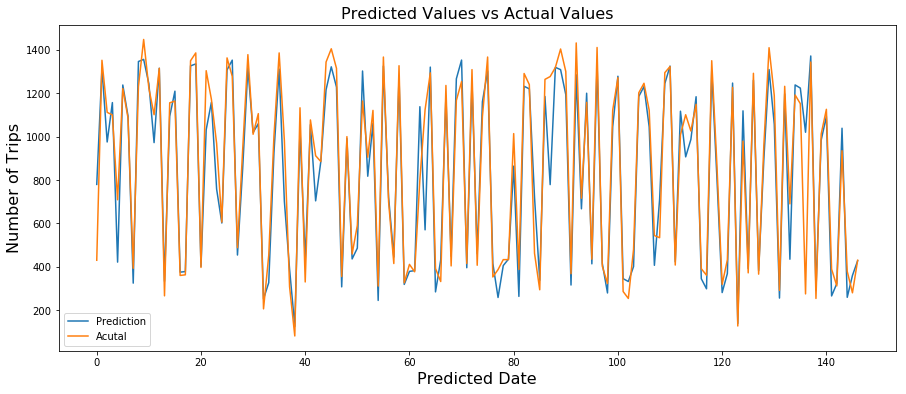

In [61]:
fs = 16
plt.figure(figsize=(15,6))
plt.plot(final_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values", fontsize = fs)
plt.show()

In [62]:
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (12,5))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:
(0, 'max_temperature_f')
(1, 'mean_temperature_f')
(2, 'min_temperature_f')
(3, 'max_dew_point_f')
(4, 'mean_dew_point_f')
(5, 'min_dew_point_f')
(6, 'max_humidity')
(7, 'mean_humidity')
(8, 'min_humidity')
(9, 'max_sea_level_pressure_inches')
(10, 'mean_sea_level_pressure_inches')
(11, 'min_sea_level_pressure_inches')
(12, 'max_visibility_miles')
(13, 'mean_visibility_miles')
(14, 'min_visibility_miles')
(15, 'max_wind_Speed_mph')
(16, 'mean_wind_speed_mph')
(17, 'precipitation_inches')
(18, 'cloud_cover')
(19, 'wind_dir_degrees')
(20, 'Fog')
(21, 'Fog-Rain')
(22, 'Normal')
(23, 'Rain')
(24, 'Rain-Thunderstorm')
(25, 'total_docks')
(26, 'holiday')
(27, 'year')
(28, 'month')
(29, 'weekday')


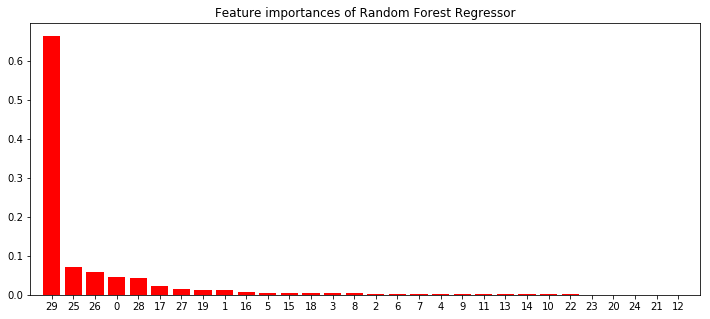

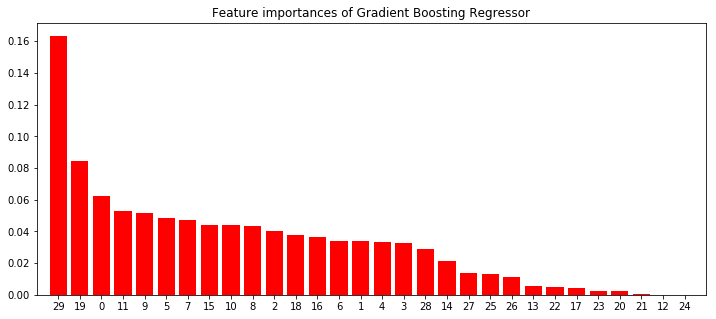

In [63]:
print("Feature ranking:")

i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "Random Forest Regressor")
plot_importances(gbr, "Gradient Boosting Regressor")